# Exercises

## Tutorial and home work 1: Classification and encoder for MNIST

### Installation

We will be using torch for the exercises. It is recommended to install a seperate conda environment for the course and install torch, torchvision, python 3.12 and matplotlib there. Check the online manuals for the installation on your computer.

We also use two other packages, torchinfo and torcheval that can be installed using pip.

The following imports all the packages used, if there are any error messages, check your installation.

### Tutorial outline 

The tutorial recaps how to do design and train a neural network using pytorch. As an exercise, the tutorial should be augmented by designing and training a different network that encodes and decodes the input image and does the classification.

In [225]:
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchinfo import summary
from torcheval.metrics import MulticlassAccuracy, MeanSquaredError

import numpy as np
import matplotlib.pyplot as plt

import wandb

### Data preparation
We will use data sets from torchvision. These data sets have to be transformed into a tensor for torch and also must be normalized if they are not already. We will use 1-channel (intensity) images from the (probably too well known :-) ) MNIST data set for this tutorial.

In [226]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

Generate the train and test data sets. Download the data if necessary.

In [227]:
data_train = torchvision.datasets.MNIST(root='data/mnist', download=True, transform=transform)

In [228]:
data_test = torchvision.datasets.MNIST(root='data/mnist', train=False, download=True, transform=transform)

In [229]:
print (f'train: {len(data_train)}')

train: 60000


### Train and validation data sets

The train data set should be further split into train and validation. We can use random split here as the data set is balanced.

In [230]:
len_train = (int)(0.8 * len(data_train))
len_val = len(data_train) - len_train

print(len_train, len_val, len(data_train))

data_train_subset, data_val_subset = torch.utils.data.random_split(
        data_train, [len_train, len_val])

48000 12000 60000


Construct data loaders for the 3 data sets.
                  

In [231]:
BATCH_SIZE = 64

data_train_loader = torch.utils.data.DataLoader(dataset=data_train_subset, shuffle=True, batch_size=BATCH_SIZE)
data_val_loader = torch.utils.data.DataLoader(dataset=data_val_subset, shuffle=False, batch_size=BATCH_SIZE)
data_test_loader = torch.utils.data.DataLoader(data_test, batch_size=64)

### Verify the images in the data set
Verify the images and also check that the range is correct

max: 1.0, min: 0.0


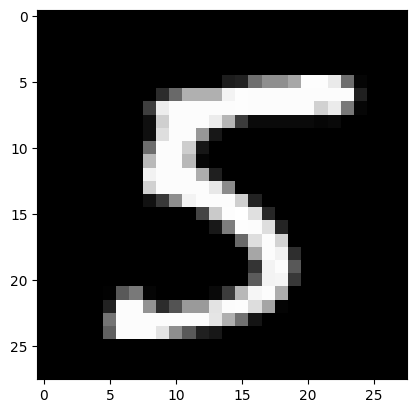

In [232]:
train_iter = iter(data_train_loader)
images, labels = next(train_iter)

image = images[0].numpy().squeeze()
print(f'max: {np.max(image)}, min: {np.min(image)}')
plt.imshow(image, cmap='gray')
plt.show()

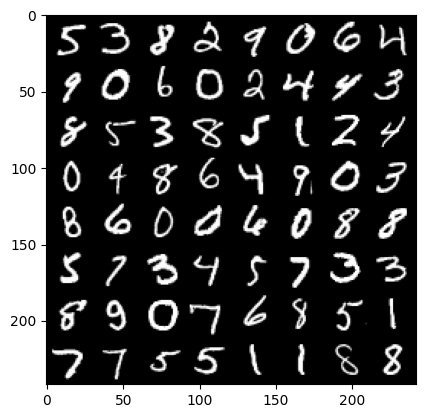

In [233]:
plt.imshow(np.transpose(torchvision.utils.make_grid(images), (1, 2, 0)))

## Define a CNN for classification
Define a convolutional neural network for classification. 

We will use a simple network for this example. This should be refined in the exercise.


In [234]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, out_channels=4, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(4, 8, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 8, 3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(72, 120),
            nn.ReLU(),
            nn.Linear(120, 10)
        )
        

    def forward(self, x):
        return self.layers.forward(x)


my_cnn = MyCNN()
print(my_cnn)

MyCNN(
  (layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=72, out_features=120, bias=True)
    (10): ReLU()
    (11): Linear(in_features=120, out_features=10, bias=True)
  )
)


### Displaying the network
The print function does not display the resulting sizes and number of parameters. The summary function from torchinfo provides similar output as the function in keras 

In [235]:
summary(my_cnn, input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MyCNN                                    [64, 10]                  --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [64, 4, 26, 26]           40
│    └─ReLU: 2-2                         [64, 4, 26, 26]           --
│    └─MaxPool2d: 2-3                    [64, 4, 13, 13]           --
│    └─Conv2d: 2-4                       [64, 8, 11, 11]           296
│    └─ReLU: 2-5                         [64, 8, 11, 11]           --
│    └─MaxPool2d: 2-6                    [64, 8, 5, 5]             --
│    └─Conv2d: 2-7                       [64, 8, 3, 3]             584
│    └─ReLU: 2-8                         [64, 8, 3, 3]             --
│    └─Flatten: 2-9                      [64, 72]                  --
│    └─Linear: 2-10                      [64, 120]                 8,760
│    └─ReLU: 2-11                        [64, 120]                 --
│    └─Lin

### Loss function and optimizer
We next define the loss function and the optimizer to use. We will use a simple optimizer for the moment

In [236]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_cnn.parameters(), lr=0.001, momentum=0.9)

### Device

In pytorch, we must specify which device to use and move the input and the model to the device. Lets first have a simple function to get the device

In [237]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        # test if it worked
        x = torch.ones(1, device=device)
        print('Using CUDA device')

    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        x = torch.ones(1, device=device)
        print('Using MPS device')
    else:
        print('Using CPU')
        device = torch.device('cpu')
    return device

In [238]:
device = get_device()

Using MPS device


### Simple train function
Lets define a simple train function for one epoch.

In [239]:
def train_one_epoch(epoch_index, model, loss_function, optimizer, device):
    model.to(device)
    model.train(True)
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(data_train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_function(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 1000 # loss per batch
            print(f'  batch {i+1} loss: {last_loss:.5f}'.format(i + 1, last_loss))
            running_loss = 0.

    return last_loss

In [240]:
EPOCHS = 2
for epoch in range(EPOCHS):
    print(f'EPOCH {epoch + 1}')

    # Make sure gradient tracking is on, and do a pass over the data
    my_cnn.train(True)
    avg_loss = train_one_epoch(epoch, my_cnn, criterion, optimizer, device)
    print(f'EPOCH {epoch + 1} Loss: {avg_loss:.5f}')


EPOCH 1
  batch 100 loss: 0.23016
  batch 200 loss: 0.22976
  batch 300 loss: 0.22949
  batch 400 loss: 0.22921
  batch 500 loss: 0.22904
  batch 600 loss: 0.22860
  batch 700 loss: 0.22807
EPOCH 1 Loss: 0.22807
EPOCH 2
  batch 100 loss: 0.22673
  batch 200 loss: 0.22491
  batch 300 loss: 0.22093
  batch 400 loss: 0.20791
  batch 500 loss: 0.15852
  batch 600 loss: 0.09497
  batch 700 loss: 0.07143
EPOCH 2 Loss: 0.07143


## Training and evaluation

The code above works, however there are a couple of things missing:
- first it would be more interesting to calculate some metrics in addition to the loss function
- then, we should evaluate the loss and the metrics on the evaluation set
- and thirdly, we would like to monitor the loss and metrics using graphics representation specially for longer training time

We will use weights and biases (wandb) for the display. Another option is to use tensorboard.

In [241]:
wandb.login()

True

### Training and evalution loop

We define our a training loop that receives the model, loss function, optimizer, metrics and the device as parameters.

There are different possibilities to do this, with wandb I find it easier to do training and evaluation in the same loop.

In [242]:
def train(epochs: int, model, loss_function, optimizer, metrics, device):
    # define the project and store some setting for the projects to compare results later.
    run = wandb.init(project="mnist-example", config={'epochs': epochs, 
                                                       'batch_size': data_train_loader.batch_size}
                                                       )
    input_count = 0
    step_count = 0
    model = model.to(device)
    
    for epoch in range(epochs):
        model.train()
        metrics.reset()
        for step, (inputs, labels) in enumerate(data_train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero your gradients for every batch!
            optimizer.zero_grad()
            # calculate results
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            train_loss = loss_function(outputs, labels)
            train_loss.backward()
            optimizer.step()

            metrics.update(predicted, labels)
            train_acc = metrics.compute()

            # wandb will store the matrics with the step across x, so we also store the epoch
            train_metrics = {'train/train_loss:': train_loss,
                       'train/train_acc': train_acc,
                       'train/epoch': epoch}

            step_count += 1

            wandb.log(train_metrics, step=step_count)

        model.eval()
        metrics.reset()
        val_loss = []
        val_steps = 0
        for step, (inputs, labels) in enumerate(data_val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)

                val_loss.append(loss_function(outputs, labels).item())
                metrics.update(predicted, labels)

        val_acc = metrics.compute()
        val_loss_mean = np.mean(val_loss)
        val_metrics = {'val/val_loss': val_loss_mean,
                       'val/val_acc' : val_acc}
        # log both metrics
        wandb.log(val_metrics, step=step_count)

        print(f"Epoch {epoch:02} Train Loss: {train_loss:.3f}, Valid Loss: {val_loss_mean:.3f}, Train Accuracy: {train_acc:.2f} Valid Acc: {val_acc:.2f}")
    wandb.finish()
                       
            

In [243]:
my_cnn = MyCNN()
my_metrics = MulticlassAccuracy(num_classes=10)
my_optimizer = optim.Adam(my_cnn.parameters(), lr=0.001)
my_loss = nn.CrossEntropyLoss()

train(10, my_cnn, criterion, my_optimizer, my_metrics, device)

Epoch 00 Train Loss: 0.185, Valid Loss: 0.191, Train Accuracy: 0.84 Valid Acc: 0.94
Epoch 01 Train Loss: 0.051, Valid Loss: 0.121, Train Accuracy: 0.95 Valid Acc: 0.96
Epoch 02 Train Loss: 0.044, Valid Loss: 0.093, Train Accuracy: 0.97 Valid Acc: 0.97
Epoch 03 Train Loss: 0.013, Valid Loss: 0.084, Train Accuracy: 0.97 Valid Acc: 0.97
Epoch 04 Train Loss: 0.068, Valid Loss: 0.071, Train Accuracy: 0.98 Valid Acc: 0.98
Epoch 05 Train Loss: 0.014, Valid Loss: 0.077, Train Accuracy: 0.98 Valid Acc: 0.97
Epoch 06 Train Loss: 0.027, Valid Loss: 0.074, Train Accuracy: 0.98 Valid Acc: 0.98
Epoch 07 Train Loss: 0.031, Valid Loss: 0.060, Train Accuracy: 0.98 Valid Acc: 0.98
Epoch 08 Train Loss: 0.004, Valid Loss: 0.062, Train Accuracy: 0.98 Valid Acc: 0.98
Epoch 09 Train Loss: 0.114, Valid Loss: 0.052, Train Accuracy: 0.99 Valid Acc: 0.98


train/epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇███
train/train_acc,▁▁▆▆▆███████████████████████████████████
train/train_loss:,█▇▃▄▃▂▂▃▂▂▂▄▅▁▂▂▁▂▁▂▁▂▁▂▁▂▁▂▂▂▁▂▂▃▁▁▃▃▂▂
val/val_acc,▁▅▆▆▇▇▇███
val/val_loss,█▄▃▃▂▂▂▁▁▁
train/epoch,9
train/train_acc,0.9851
train/train_loss:,0.11383
val/val_acc,0.98217
val/val_loss,0.0521


## Exercise 1.1: Autoencoder

In exercise 1.1, you should implement an autoencoder. In an autoencoder, we would like to compress the input image into a small representation, this is the encoder part and then decode this representation again into an image.

The resulting image should be similar to the input image.

The size of the encoded representation, the so called latent variables should be a parameter to the class.

In [244]:
class LinearAutoencoder(nn.Module):
    def __init__(self, latent_dim: int, input_dim: int = 28, input_channels: int = 1):
        super(LinearAutoencoder,self).__init__()

        self.input_dim = input_dim
        self.input_channels = input_channels

        self.encoder = nn.Sequential(
            nn.Linear(input_dim * input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),

            # alternative: conv3d,relu,conv3d,relu,flatten,linear
            )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim * input_dim),
            nn.Sigmoid()
            # alternative: linear, relu, unflatten, convTranspose2d, ConvTranspose2d, conv2d, sigmoid
            )

    def forward(self, x):
        # Flatten (batch, input_channels, input_dim, input_dim) → (batch, input_channels * input_dim * input_dim)
        x = x.view(x.size(0), -1)

        enc = self.encoder(x)
        dec = self.decoder(enc)

        # Reshape back to image (batch, input_channels, input_dim, input_dim)
        dec = dec.view(-1, self.input_channels, self.input_dim, self.input_dim)

        return dec

linear_autoencoder = LinearAutoencoder(latent_dim=10, input_dim=28, input_channels=1)
print(linear_autoencoder)
summary(linear_autoencoder)

LinearAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


Layer (type:depth-idx)                   Param #
LinearAutoencoder                        --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       100,480
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       1,290
├─Sequential: 1-2                        --
│    └─Linear: 2-4                       1,408
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       101,136
│    └─Sigmoid: 2-7                      --
Total params: 204,314
Trainable params: 204,314
Non-trainable params: 0

Next steps:

- Adapt the training loop above for the autoencoder
- Train the autoencoder, adjusting hyper parameters if necessary
- Visualize the results, i.e. the decoded image
- Try different number of latent variables, for example 2 and 10
- Visualize the latent variables (for 2)

In [245]:
def train_autoencoder(epochs: int, model: nn.Module, loss_function, optimizer, metrics, device):
    # define the project and store some setting for the projects to compare results later.
    run = wandb.init(project="autoencoder", config={'epochs': epochs,
                                                       'batch_size': data_train_loader.batch_size}
                                                       )

    step_count = 0
    model = model.to(device)
    loss_function = loss_function.to(device)
    metrics = metrics.to(device)

    for epoch in range(epochs):
        model.train()
        metrics.reset()

        for step, (inputs, _) in enumerate(data_train_loader):
            inputs = inputs.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            train_loss = loss_function(outputs, inputs)
            train_loss.backward()
            optimizer.step()

            metrics.update(torch.flatten(outputs), torch.flatten(inputs))
            train_acc = metrics.compute()

            # wandb will store the metrics with the step across x, so we also store the epoch
            train_metrics = {'train/train_loss:': train_loss,
                       'train/train_acc': train_acc,
                       'train/epoch': epoch}

            step_count += 1

            wandb.log(train_metrics, step=step_count)

        model.eval()
        metrics.reset()
        val_loss = []

        for step, (inputs, _) in enumerate(data_val_loader):
            inputs = inputs.to(device)

            with torch.no_grad():
                outputs = model(inputs)

                val_loss.append(loss_function(outputs, inputs).item())
                metrics.update(torch.flatten(outputs), torch.flatten(inputs))

        val_acc = metrics.compute()
        val_loss_mean = np.mean(val_loss)
        val_metrics = {'val/val_loss': val_loss_mean,
                       'val/val_acc' : val_acc}
        # log both metrics
        wandb.log(val_metrics, step=step_count)

        print(f"Epoch {epoch:02} Train Loss: {train_loss:.3f}, Valid Loss: {val_loss_mean:.3f}, Train Accuracy: {train_acc:.2f} Valid Acc: {val_acc:.2f}")

    wandb.finish()

In [246]:
model = LinearAutoencoder(latent_dim=10, input_dim=28, input_channels=1)
metrics = MeanSquaredError()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss = nn.MSELoss()

In [247]:
train_autoencoder(
    epochs=10,
    model=model,
    loss_function=loss,
    optimizer=optimizer,
    metrics=metrics,
    device=device
    )

Epoch 00 Train Loss: 0.026, Valid Loss: 0.027, Train Accuracy: 0.04 Valid Acc: 0.03
Epoch 01 Train Loss: 0.023, Valid Loss: 0.023, Train Accuracy: 0.02 Valid Acc: 0.02
Epoch 02 Train Loss: 0.022, Valid Loss: 0.022, Train Accuracy: 0.02 Valid Acc: 0.02
Epoch 03 Train Loss: 0.022, Valid Loss: 0.021, Train Accuracy: 0.02 Valid Acc: 0.02
Epoch 04 Train Loss: 0.019, Valid Loss: 0.020, Train Accuracy: 0.02 Valid Acc: 0.02
Epoch 05 Train Loss: 0.020, Valid Loss: 0.020, Train Accuracy: 0.02 Valid Acc: 0.02
Epoch 06 Train Loss: 0.019, Valid Loss: 0.019, Train Accuracy: 0.02 Valid Acc: 0.02
Epoch 07 Train Loss: 0.018, Valid Loss: 0.019, Train Accuracy: 0.02 Valid Acc: 0.02
Epoch 08 Train Loss: 0.022, Valid Loss: 0.019, Train Accuracy: 0.02 Valid Acc: 0.02
Epoch 09 Train Loss: 0.017, Valid Loss: 0.018, Train Accuracy: 0.02 Valid Acc: 0.02


train/epoch,▁▁▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▆▆▆▆▆▇▇▇▇██████
train/train_acc,█▆▅▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/train_loss:,█▅▄▃▂▂▂▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▂▂▁▂▂▁▁▁▁▁▂
val/val_acc,█▅▄▃▃▂▂▁▁▁
val/val_loss,█▅▄▃▃▂▂▁▁▁
train/epoch,9
train/train_acc,0.01839
train/train_loss:,0.01706
val/val_acc,0.0184
val/val_loss,0.0184


In [252]:
def visualize(model):
    # Visualize some of the decoded images:
    n = 5
    truths = np.random.randint(0, data_test.data.shape[0], size=n)

    model.to(device)
    model.eval()

    f, ax = plt.subplots(n, 2)
    ax[0][0].title.set_text("Truths")
    ax[0][1].title.set_text("Predictions")

    for i in range(n):
        truth = data_test.data[truths[i]].type(torch.float).to(device)
        decoded = model(truth.reshape(-1, 28*28)).reshape(28, 28)

        ax[i][0].imshow(truth.reshape(28, 28).detach().cpu())
        ax[i][1].imshow(decoded.detach().cpu())

    plt.show()

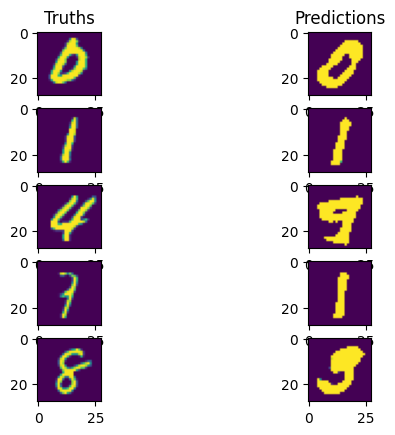

In [257]:
visualize(model)

# Visualize Decoded Images using `latent_dim = 2`

train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅██████████
train/train_acc,█▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/train_loss:,█▄▅▂▂▃▂▃▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▂▂▁▂▂▂▂▁▂
val/val_acc,█▁
val/val_loss,█▁
train/epoch,2
train/train_acc,0.04834
train/train_loss:,0.04586
val/val_acc,0.049
val/val_loss,0.049


Epoch 00 Train Loss: 0.049, Valid Loss: 0.051, Train Accuracy: 0.06 Valid Acc: 0.05
Epoch 01 Train Loss: 0.050, Valid Loss: 0.048, Train Accuracy: 0.05 Valid Acc: 0.05
Epoch 02 Train Loss: 0.046, Valid Loss: 0.047, Train Accuracy: 0.05 Valid Acc: 0.05
Epoch 03 Train Loss: 0.042, Valid Loss: 0.046, Train Accuracy: 0.05 Valid Acc: 0.05
Epoch 04 Train Loss: 0.043, Valid Loss: 0.045, Train Accuracy: 0.05 Valid Acc: 0.05
Epoch 05 Train Loss: 0.044, Valid Loss: 0.045, Train Accuracy: 0.04 Valid Acc: 0.04
Epoch 06 Train Loss: 0.044, Valid Loss: 0.044, Train Accuracy: 0.04 Valid Acc: 0.04
Epoch 07 Train Loss: 0.043, Valid Loss: 0.044, Train Accuracy: 0.04 Valid Acc: 0.04
Epoch 08 Train Loss: 0.042, Valid Loss: 0.044, Train Accuracy: 0.04 Valid Acc: 0.04
Epoch 09 Train Loss: 0.045, Valid Loss: 0.044, Train Accuracy: 0.04 Valid Acc: 0.04


train/epoch,▁▁▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇███
train/train_acc,█▇▆▆▅▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/train_loss:,█▇█▆▆▃▅▂▂▄▂▃▄▄▃▅▁▂▄▃▃▄▄▃▃▂▂▂▂▄▃▁▃▅▁▂▂▃▃▂
val/val_acc,█▅▄▃▂▂▂▁▁▁
val/val_loss,█▅▄▃▂▂▂▁▁▁
train/epoch,9
train/train_acc,0.04338
train/train_loss:,0.04503
val/val_acc,0.04359
val/val_loss,0.04358


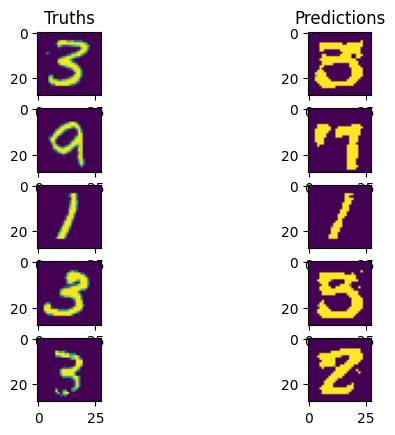

In [258]:
model = LinearAutoencoder(latent_dim=2, input_dim=28, input_channels=1)
metrics = MeanSquaredError()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss = nn.MSELoss()

train_autoencoder(epochs=10, model=model, loss_function=loss, optimizer=optimizer, metrics=metrics, device=device)
visualize(model)

## Exercise 1.2: Two headed network with autoencoder and classificator

Next we want to train a model that can do both the autoencoder and the classification. One idea of this approach is to force the model to learn a representation that works well for reconstruction and classification. The classification head should branch off after the encoding part.

In [391]:
class EncoderAndClassificator(nn.Module):
    def __init__(self, latent_dim: int, num_classes: int):
        super(EncoderAndClassificator,self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
            )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
            )
        self.classifier = nn.Sequential (
            nn.Linear(latent_dim, num_classes),
            nn.ReLU(),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        # Flatten (batch, input_channels, input_dim, input_dim) → (batch, input_channels * input_dim * input_dim)
        x = x.view(x.size(0), -1)

        enc = self.encoder(x)

        dec = self.decoder(enc)
        # Reshape back to image (batch, input_channels, input_dim, input_dim)
        dec = dec.view(-1, 1, 28, 28)

        logits = self.classifier(enc)
        return dec, logits

Next steps:
- Adapt the training loop, how is the loss calculated?
- Train the model and compare it to the two seperate models above

In [392]:
model = EncoderAndClassificator(latent_dim=2, num_classes = 10)
metrics = MeanSquaredError(), MulticlassAccuracy(num_classes=10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss = nn.MSELoss(), nn.CrossEntropyLoss()

In [393]:
def train_encoder_and_classifier(epochs: int, model: nn.Module, loss_function, optimizer, metrics, device):
    # define the project and store some setting for the projects to compare results later.
    run = wandb.init(project="encoder_and_classifier", config={'epochs': epochs,
                                                       'batch_size': data_train_loader.batch_size}
                                                       )

    step_count = 0
    model = model.to(device)

    loss_dec, loss_logits = loss_function
    metrics_dec, metrics_logits = metrics

    loss_dec = loss_dec.to(device)
    loss_logits = loss_logits.to(device)
    metrics_dec = metrics_dec.to(device)
    metrics_logits = metrics_logits.to(device)

    for epoch in range(epochs):
        model.train()

        metrics_dec.reset()
        metrics_logits.reset()

        for step, (inputs, labels) in enumerate(data_train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs_dec, outputs_logits = model(inputs)

            train_loss_dec, train_loss_logits = loss_dec(outputs_dec, inputs), loss_logits(outputs_logits, labels)

            # TODO: The loss values should be weighted (or normalized if possible) because their scale can differ dramatically
            total_loss = train_loss_logits + train_loss_dec
            total_loss.backward()
            optimizer.step()

            outputs_logits_max = torch.max(outputs_logits, dim = 1).values

            metrics_dec.update(torch.flatten(outputs_dec), torch.flatten(inputs))
            metrics_logits.update(outputs_logits_max, labels)

            train_acc_dec = metrics_dec.compute()
            train_acc_logits = metrics_logits.compute()

            # wandb will store the metrics with the step across x, so we also store the epoch
            train_metrics = {'train/train_loss_dec:': train_loss_dec,
                       'train/train_acc_dec': train_acc_dec,
                       'train/train_loss_logits:': train_loss_logits,
                       'train/train_acc_logits': train_acc_logits,
                       'train/epoch': epoch}

            step_count += 1

            wandb.log(train_metrics, step=step_count)

        model.eval()
        metrics_dec.reset()
        metrics_logits.reset()
        val_loss_dec = []
        val_loss_logits = []

        for step, (inputs, labels) in enumerate(data_val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs_dec, outputs_logits = model(inputs)

                outputs_logits_max = torch.max(outputs_logits, dim = 1).values

                val_loss_dec.append(loss_dec(outputs_dec, inputs).item())
                val_loss_logits.append(loss_logits(outputs_logits, labels).item())

                metrics_dec.update(torch.flatten(outputs_dec), torch.flatten(inputs))
                metrics_logits.update(outputs_logits_max, labels)

        val_acc_dec = metrics_dec.compute()
        val_acc_logits = metrics_dec.compute()

        val_loss_mean_dec = np.mean(val_loss_dec)
        val_loss_mean_logits = np.mean(val_loss_logits)
        val_metrics = {'val/val_loss_dec': val_loss_mean_dec,
                       'val/val_acc_dec' : val_acc_dec,
                       'val/val_loss_logits': val_loss_mean_logits,
                       'val/val_acc_logits' : val_acc_logits}
        # log both metrics
        wandb.log(val_metrics, step=step_count)

        print(f"Epoch {epoch:02} Train Loss Dec: {train_loss_dec:.3f}, Valid Loss Dec: {val_loss_mean_dec:.3f}, Train Accuracy Dec: {train_acc_dec:.2f} Valid Acc Dec: {val_acc_dec:.2f}")

    wandb.finish()

In [394]:
train_encoder_and_classifier(epochs=10, model=model, loss_function=loss, optimizer=optimizer, metrics=metrics, device=device)

Epoch 00 Train Loss Dec: 0.058, Valid Loss Dec: 0.056, Train Accuracy Dec: 0.06 Valid Acc Dec: 0.06
Epoch 01 Train Loss Dec: 0.056, Valid Loss Dec: 0.055, Train Accuracy Dec: 0.06 Valid Acc Dec: 0.05
Epoch 02 Train Loss Dec: 0.055, Valid Loss Dec: 0.054, Train Accuracy Dec: 0.05 Valid Acc Dec: 0.05
Epoch 03 Train Loss Dec: 0.057, Valid Loss Dec: 0.054, Train Accuracy Dec: 0.05 Valid Acc Dec: 0.05
Epoch 04 Train Loss Dec: 0.056, Valid Loss Dec: 0.053, Train Accuracy Dec: 0.05 Valid Acc Dec: 0.05
Epoch 05 Train Loss Dec: 0.054, Valid Loss Dec: 0.053, Train Accuracy Dec: 0.05 Valid Acc Dec: 0.05
Epoch 06 Train Loss Dec: 0.051, Valid Loss Dec: 0.052, Train Accuracy Dec: 0.05 Valid Acc Dec: 0.05
Epoch 07 Train Loss Dec: 0.053, Valid Loss Dec: 0.052, Train Accuracy Dec: 0.05 Valid Acc Dec: 0.05
Epoch 08 Train Loss Dec: 0.054, Valid Loss Dec: 0.051, Train Accuracy Dec: 0.05 Valid Acc Dec: 0.05
Epoch 09 Train Loss Dec: 0.051, Valid Loss Dec: 0.051, Train Accuracy Dec: 0.05 Valid Acc Dec: 0.05


train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
train/train_acc_dec,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/train_acc_logits,▁▁▁▁▁▁▁▃▁▁█▅▅▁▁▆▆▁▁▁▃▂▄▄▅▁▆▆▆▅▄▃▃▁▁▄▃▁▁▃
train/train_loss_dec:,▇▅█▆▆▇▅▇▇▆▆▂█▅▆▅▆▇▇█▇▅▅▇█▇▆▅▆▄▅▃▄█▅▄▁▇▃▅
train/train_loss_logits:,▆█▇▆▆▆▅▆▅▅▄▃▄▂▄▃▄▃▄▃▃▂▃▂▃▂▃▃▃▂▂▂▁▁▁▂▁▁▃▂
val/val_acc_dec,█▆▅▄▄▃▂▂▁▁
val/val_acc_logits,█▆▅▄▄▃▂▂▁▁
val/val_loss_dec,█▆▅▄▄▃▂▂▁▁
val/val_loss_logits,█▅▄▄▃▂▂▁▁▁
train/epoch,9
train/train_acc_dec,0.05138


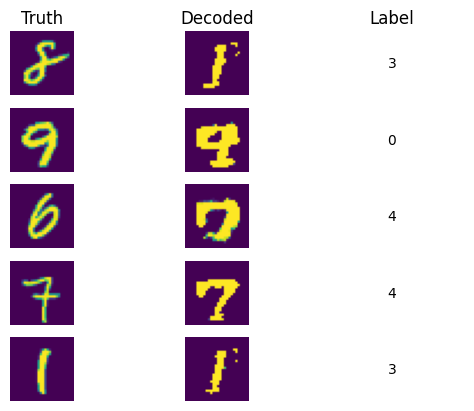

In [395]:
# Visualize some of the decoded images:
n = 5
truths = np.random.randint(0, data_test.data.shape[0], size=n)

model.to(device)
model.eval()

f, ax = plt.subplots(n, 3)
ax[0][0].title.set_text("Truth")
ax[0][1].title.set_text("Decoded")
ax[0][2].title.set_text("Label")

for i in range(n):
    truth = data_test.data[truths[i]].type(torch.float).to(device)
    decoded, logits = model(truth.reshape(-1, 28*28))

    decoded = decoded.reshape(28, 28)
    logit_idx = torch.max(logits, dim=1).indices.cpu()
    logit_label = labels.cpu()[logit_idx]

    ax[i][0].axis('off')
    ax[i][1].axis('off')
    ax[i][2].axis('off')

    ax[i][0].imshow(truth.reshape(28, 28).detach().cpu())
    ax[i][1].imshow(decoded.detach().cpu())
    ax[i][2].text(0.5, 0.5, logit_label.item(), ha='center', va='center')

plt.show()